In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob

import sys
sys.path.append('../python')
from functions import *
from models import *

import tensorflow as tf
from livelossplot import PlotLossesKeras
os.environ["CUDA_VISIBLE_DEVICES"] = "2" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# One patch

### Load a file and label the stream stars

In [ ]:
df = load_file()

In [ ]:
make_plots(df)

In [ ]:
plt.figure(dpi=150)
plt.scatter(df[df.stream]['α_wrapped']-360, df[df.stream]['δ'], marker='.')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\delta$")
plt.title("GD1 Stars");
plt.xlim(-241,-135);
plt.ylim(-10,65);

# All patches

In [2]:
patch_list = [
 # b = 33.7 
 '../gaia_data/gd1/gaiascan_l195.0_b33.7_ra128.4_dec28.8.npy',
 '../gaia_data/gd1/gaiascan_l210.0_b33.7_ra132.6_dec16.9.npy',
 '../gaia_data/gd1/gaiascan_l225.0_b33.7_ra138.1_dec5.7.npy', 
 # b = 41.8 
 '../gaia_data/gd1/gaiascan_l187.5_b41.8_ra136.5_dec36.1.npy',
 '../gaia_data/gd1/gaiascan_l202.5_b41.8_ra138.8_dec25.1.npy',
 '../gaia_data/gd1/gaiascan_l217.5_b41.8_ra142.7_dec14.5.npy', 
 # b = 50.2 
 '../gaia_data/gd1/gaiascan_l99.0_b50.2_ra224.7_dec60.6.npy',
 '../gaia_data/gd1/gaiascan_l117.0_b50.2_ra202.4_dec66.5.npy',
 '../gaia_data/gd1/gaiascan_l135.0_b50.2_ra174.3_dec65.1.npy',
 '../gaia_data/gd1/gaiascan_l153.0_b50.2_ra156.2_dec57.5.npy',
 '../gaia_data/gd1/gaiascan_l171.0_b50.2_ra148.6_dec47.0.npy',
 '../gaia_data/gd1/gaiascan_l189.0_b50.2_ra146.9_dec35.6.npy',
 '../gaia_data/gd1/gaiascan_l207.0_b50.2_ra148.6_dec24.2.npy',
 # b = 58.4 
 '../gaia_data/gd1/gaiascan_l101.2_b58.4_ra212.7_dec55.2.npy',
 '../gaia_data/gd1/gaiascan_l123.8_b58.4_ra192.0_dec58.7.npy',
 '../gaia_data/gd1/gaiascan_l146.2_b58.4_ra171.8_dec54.7.npy',
 '../gaia_data/gd1/gaiascan_l168.8_b58.4_ra160.5_dec45.5.npy',
 '../gaia_data/gd1/gaiascan_l191.2_b58.4_ra156.9_dec34.1.npy',
 # b = 66.4 
 '../gaia_data/gd1/gaiascan_l105.0_b66.4_ra203.7_dec49.1.npy',
 '../gaia_data/gd1/gaiascan_l135.0_b66.4_ra185.4_dec50.0.npy',
 '../gaia_data/gd1/gaiascan_l165.0_b66.4_ra171.4_dec43.0.npy',    
]

In [3]:
# ### Slow -- make the dataframes (better in a separate screen, tbh) 
# for file in tqdm(patch_list):
#     df = load_file(file)
#     df["patch_id"] = patch_list.index(file)
#     df.to_hdf(file[:-4]+".h5", "df")

In [4]:
### Fast -- load the dataframes & concatenate 
dfs = []
for file in tqdm(patch_list):
    df = pd.read_hdf(file[:-4]+".h5")
#     print(df.patch_id.value_counts())
    dfs.append(df)
df_all = pd.concat(dfs)

  5%|▍         | 1/21 [00:00<00:12,  1.59it/s]

0    2191192
Name: patch_id, dtype: int64


 10%|▉         | 2/21 [00:01<00:10,  1.76it/s]

1    2125450
Name: patch_id, dtype: int64


 14%|█▍        | 3/21 [00:01<00:09,  1.83it/s]

2    2095514
Name: patch_id, dtype: int64


 19%|█▉        | 4/21 [00:02<00:07,  2.13it/s]

3    1384387
Name: patch_id, dtype: int64


 24%|██▍       | 5/21 [00:02<00:06,  2.38it/s]

4    1329283
Name: patch_id, dtype: int64


 29%|██▊       | 6/21 [00:02<00:05,  2.60it/s]

5    1260670
Name: patch_id, dtype: int64


 33%|███▎      | 7/21 [00:03<00:05,  2.63it/s]

6    1483584
Name: patch_id, dtype: int64


 38%|███▊      | 8/21 [00:03<00:04,  2.77it/s]

7    1292226
Name: patch_id, dtype: int64


 43%|████▎     | 9/21 [00:03<00:04,  2.95it/s]

8    1171270
Name: patch_id, dtype: int64


 48%|████▊     | 10/21 [00:03<00:03,  3.13it/s]

9    1095486
Name: patch_id, dtype: int64


 52%|█████▏    | 11/21 [00:04<00:03,  3.30it/s]

10    1047372
Name: patch_id, dtype: int64


 57%|█████▋    | 12/21 [00:04<00:02,  3.42it/s]

11    999435
Name: patch_id, dtype: int64


 62%|██████▏   | 13/21 [00:04<00:02,  3.54it/s]

12    930170
Name: patch_id, dtype: int64


 67%|██████▋   | 14/21 [00:05<00:02,  3.47it/s]

13    1199595
Name: patch_id, dtype: int64


 71%|███████▏  | 15/21 [00:05<00:01,  3.57it/s]

14    1043067
Name: patch_id, dtype: int64


 76%|███████▌  | 16/21 [00:05<00:01,  3.68it/s]

15    945108
Name: patch_id, dtype: int64


 81%|████████  | 17/21 [00:05<00:01,  3.79it/s]

16    876262
Name: patch_id, dtype: int64


 86%|████████▌ | 18/21 [00:05<00:00,  4.04it/s]

17    823614
Name: patch_id, dtype: int64


 90%|█████████ | 19/21 [00:06<00:00,  3.96it/s]

18    1043465
Name: patch_id, dtype: int64


 95%|█████████▌| 20/21 [00:06<00:00,  3.85it/s]

19    899529
Name: patch_id, dtype: int64


100%|██████████| 21/21 [00:06<00:00,  3.11it/s]

20    799393
Name: patch_id, dtype: int64


In [5]:
df_all.patch_id.value_counts()

0     2191192
1     2125450
2     2095514
6     1483584
3     1384387
4     1329283
7     1292226
5     1260670
13    1199595
8     1171270
9     1095486
10    1047372
18    1043465
14    1043067
11     999435
15     945108
12     930170
19     899529
16     876262
17     823614
20     799393
Name: patch_id, dtype: int64

In [8]:
np.min(df_all['α_wrapped'] - 360)

-248.7900390625

In [9]:
np.max(df_all['α_wrapped'] - 360)

-103.48583984375

In [10]:
np.min(df_all['δ'])

-9.338991165161133

In [12]:
np.max(df_all['δ'])

81.46185302734375

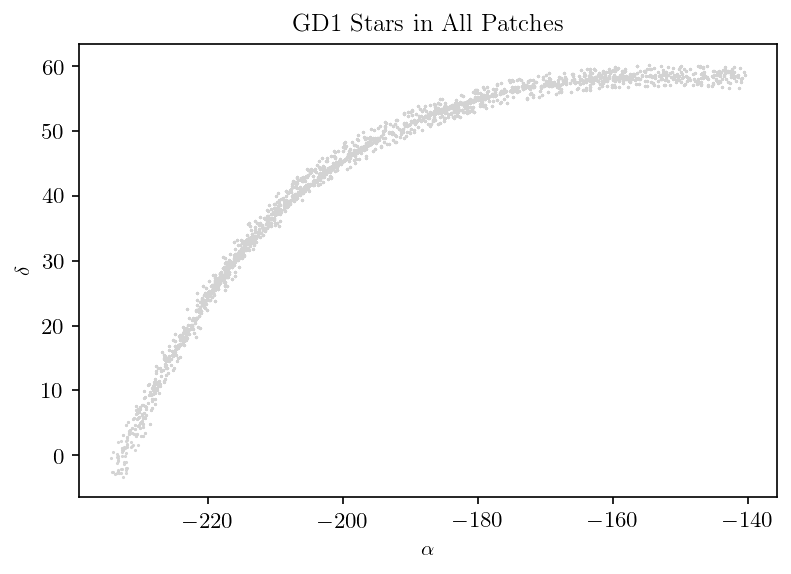

In [7]:
plt.figure(dpi=150)
plt.scatter(df_all[df_all.stream]['α_wrapped'] - 360, df_all[df_all.stream]['δ'], marker='.', color='lightgray', s=1)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\delta$")
plt.title("GD1 Stars in All Patches");

In [ ]:
for patch_id in [0,1,2]: #df_all.patch_id.unique(): 
    df = df_all[df_all.patch_id == patch_id]
    
    fig = plt.figure(figsize=(12,4), dpi=200, tight_layout=True)
    ax = fig.add_subplot(131)
    ax.hist2d(df['ϕ'], df['λ'], bins=100, cmap="Blues");
    ax.scatter(df[df.stream]['ϕ'], df[df.stream]['λ'], marker='.', s=5, color='red')
    ax.set_xlabel(r'$\phi~(^\circ)$',fontsize=20)
    ax.set_ylabel(r'$\lambda~(^\circ)$',fontsize=20)
    ax.set_xlim(-11,11);
    ax.set_ylim(-11,11);

    ax = fig.add_subplot(132)
    ax.hexbin(df['μ_ϕcosλ'], df['μ_λ'], cmap='Blues', bins='log', gridsize=400, mincnt=1)
    ax.scatter(df[df.stream]['μ_ϕcosλ'], df[df.stream]['μ_λ'], marker='.', s=5, color='red')
    ax.set_xlim(-30,15)
    ax.set_ylim(-30,15)
    ax.set_xlabel(r'$\mu_\phi^*$ (mas/yr)',fontsize=20)
    ax.set_ylabel(r'$\mu_\lambda$ (mas/yr)',fontsize=20)

    ax = fig.add_subplot(133)
    ax.hexbin(df['b-r'], df['g'], cmap='Blues', bins='log', gridsize=400, mincnt=1)
    ax.scatter(df[df.stream]['b-r'], df[df.stream]['g'], marker='.', s=5, color='red')
    ax.set_xlabel(r'$b-r$',fontsize=20)
    ax.set_ylabel(r'$g$',fontsize=20)
    ax.set_xlim(0,3)
    ax.set_ylim(9,20.2)
    ax.invert_yaxis() 

In [ ]:
### α0 and δ0 offsets of each patch 

offsets = {
    "patch_0" : (128.4, 28.8),
    "patch_1" : (132.6, 16.9),
    "patch_2" : (138.1, 5.7),
    "patch_3" : (136.5, 36.1),
    "patch_4" : (138.8, 25.1),
    "patch_5" : (142.7, 14.5),
    "patch_6" : (224.7, 60.6),
    "patch_7" : (202.4, 66.5),
    "patch_8" : (174.3, 65.1),
    "patch_9" : (156.2, 57.5),
    "patch_10" : (148.6, 47.0),
    "patch_11" : (146.9, 35.6),
    "patch_12" : (148.6, 24.2),
    "patch_13" : (212.7, 55.2),
    "patch_14" : (192.0, 58.7),
    "patch_15" : (171.8, 54.7),
    "patch_16" : (160.5, 45.5),
    "patch_17" : (156.9, 34.1),
    "patch_18" : (203.7, 49.1),
    "patch_19" : (185.4, 50.0),
    "patch_20" : (171.4, 43.0),
          }

patches = []
for patch_id in range(21): 
    patch = df_all[df_all.patch_id == patch_id]
    patch['ϕ_absolute'] = patch['ϕ'] + offsets['patch_'+str(patch_id)][0]
    patch['λ_absolute'] = patch['λ'] + offsets['patch_'+str(patch_id)][1]
    patches.append(patch)
df = pd.concat(patches)

plt.figure(dpi=200, figsize=(5,3.5))
plt.hist2d(df['ϕ_absolute'], df['λ_absolute'], bins=200);
plt.scatter(df[df.stream]['ϕ_absolute'], df[df.stream]['λ_absolute'], color="magenta", marker='.', s=1)
plt.xlabel(r'$\phi$');
plt.ylabel(r'$\lambda$');

plt.figure(dpi=200, figsize=(5,3.5))
plt.hist2d(df['α_wrapped'] - 360, df['δ'], bins=200);
plt.scatter(df[df.stream]['α_wrapped'] - 360, df[df.stream]['δ'], color="magenta", marker='.', s=1)
plt.xlabel(r'$\alpha$');
plt.ylabel(r'$\delta$');

## Megapatch

In [ ]:
### Fast -- load the dataframes & concatenate 
dfs = []
for file in tqdm(patch_list):
    df = pd.read_hdf(file[:-4]+".h5")
    dfs.append(df)
df_all = pd.concat(dfs)

In [ ]:
df_all.reset_index(inplace=True)
df_all.drop_duplicates(subset = 'index')
df_all.drop_duplicates(subset=['α','δ', 'μ_α', 'μ_δ', 'b-r', 'g'], inplace=True)

In [ ]:
df_all.shape

In [ ]:
np.sum(df_all.stream)

In [ ]:
plt.figure(dpi=150)
plt.scatter(df_all[df_all.stream]['α_wrapped'] - 360, df_all[df_all.stream]['δ'], marker='.', color='lightgray', s=1)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\delta$")
plt.title("GD1 Stars in All Patches");

In [ ]:
dfs = []
for i in tqdm(range(20)): 
    df = df_all[(df_all.g < 20.2) & (0.5 <= df_all['b-r']) & (df_all['b-r'] <= 1)]
#     df = df[df.g > 17]
#     df = df[df['μ_λ'] < 2]
#     df = df[df['μ_λ'] > -15]
#     df = df[df['μ_ϕcosλ'] < -1]
#     df = df[df['μ_ϕcosλ'] > -10]
    df = df[df.patch_id == i]

    gd1_frame = GD1Koposov10()

    ### Transform all the stars in the patch
    coord_icrs = SkyCoord(ra=(df['α_wrapped'] - 360)*u.degree, dec=df.δ*u.degree, frame='icrs')
    coord_gd1 = coord_icrs.transform_to(gd1_frame)
    df['ϕ1'] = coord_gd1.phi1.degree
    df['ϕ2'] = coord_gd1.phi2.degree
    
    ### Draw a box around the stream
    df = df[df['ϕ2'] > -5]
    df = df[df['ϕ2'] < 3]
    dfs.append(df)

    markersize = 5
    plt.figure(dpi=200, figsize=(10,4))
    plt.scatter(df['ϕ1'], df['ϕ2'], marker='.', s=markersize, color="lightgray", label="Background")
    plt.scatter(df[df.stream]['ϕ1'], df[df.stream]['ϕ2'], marker='.', s=markersize, color="crimson", label="GD-1")
    plt.legend(fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel(r"$\phi_1$ [\textdegree]", fontsize=18);
    plt.ylabel(r"$\phi_2$ [\textdegree]", fontsize=18);

In [ ]:
new_df = pd.concat(dfs)

In [ ]:
plt.scatter(new_df[new_df.stream == False]['ϕ1'], new_df[new_df.stream == False]['ϕ2'], color='lightgray')
plt.scatter(new_df[new_df.stream == True]['ϕ1'], new_df[new_df.stream == True]['ϕ2'], color='crimson')
plt.ylim(-10,10);

In [ ]:
len(new_df[new_df.stream])

In [ ]:
plt.figure(dpi=150)
plt.scatter(new_df[new_df.stream]['α_wrapped'] - 360, new_df[new_df.stream]['δ'], marker='.', color='lightgray', s=1)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\delta$")
plt.title("GD1 Stars in All Patches");

In [ ]:
df_slice = signal_sideband(new_df, sr_max = -8, sr_min = -15, sb_min = -16, sb_max = -10)

In [ ]:
save_folder = "megapatch"

if save_folder is not None: 
    os.makedirs(save_folder, exist_ok=True)
    
tf.keras.backend.clear_session()
test = train(df_slice, verbose=False, save_folder = save_folder)

In [ ]:
test = pd.read_hdf("./megapatch/df_test.h5")

In [ ]:
test = test[test['ϕ1'] < 10]
test = test[test.g < 20.2]
test = test[(0.5 <= test['b-r']) & (test['b-r'] <= 1)]
test = test[(test['μ_λ']**2 + test['μ_ϕcosλ']**2) > 4]

In [ ]:
test.stream.value_counts()

In [ ]:
cwola = test.sort_values('nn_score',ascending=False)[:100]

In [ ]:
plt.scatter(test[test.stream].α_wrapped - 360, test[test.stream].δ, marker='.', s=markersize, 
            color="lightgray", label="GD-1")
plt.scatter(cwola[cwola.stream == False].α_wrapped - 360, cwola[cwola.stream == False].δ, marker='.', s=markersize, 
            color="dodgerblue", label="CWoLa Non-Match")
plt.scatter(cwola[cwola.stream].α_wrapped - 360, cwola[cwola.stream].δ, marker='.', s=markersize, 
            color="crimson", label="CWoLa Match)")

In [ ]:
plot_results(test)

# Remake Via Machinae plot from test dataframes saved during the training

In [1]:
def fiducial_cuts(df):
    df = df[df.g < 20.2] # reduces streaking 
    df = df[(0.5 <= df['b-r']) & (df['b-r'] <= 1)] # cold stellar streams in particular
#     df = df[np.sqrt((df['μ_ϕcosλ'])**2 + (df['μ_λ'])**2) > 5] # exclude stars near 0 proper motion
    df = df[(np.abs(df['μ_ϕcosλ']) > 2) | (np.abs(df['μ_λ']) > 2)] # exclude stars near 0 proper motion
#     df = df[df['μ_ϕcosλ'] < -1]
#     df = df[df['g'] > -df['b-r'] + 18.5]
#     df = df[df.g > (15*df['b-r']+8)]

#     df = df[df.g > (7*df['b-r']+13.5)]
#     df = df[df.patch_id != 2]
#     df = df[df.patch_id != 6]
    return df

In [2]:
all_gd1_stars = []
cwola_stars = []

files = sorted(glob("../trained_models/new_sr1_sb3_gpu/patches/patch*/df_test.h5"))

for file in files: # use all files to create stream stars
    test = pd.read_hdf(file)
    test = fiducial_cuts(test)
    all_gd1_stars.append(test[test.stream])    

for file in files:
    test = pd.read_hdf(file)
    test = fiducial_cuts(test)
    n_top_stars = np.min([len(test[test.stream]),100])
    patch_top_stars = test.sort_values('nn_score',ascending=False)[:n_top_stars]
    try: 
        purity = 100*len(patch_top_stars[patch_top_stars.stream])/len(patch_top_stars)
    except:
        print("skipping "+str(file))
        continue
# #     print(purity)
    if purity < 0:
        print(file)
        continue
    else:
        cwola_stars.append(patch_top_stars)
    
all_gd1_stars = pd.concat([df for df in all_gd1_stars])
cwola_stars = pd.concat([df for df in cwola_stars])

all_gd1_stars.reset_index(inplace=True)
all_gd1_stars.drop_duplicates(subset = 'index')
all_gd1_stars.drop_duplicates(subset=['α','δ', 'μ_α', 'μ_δ', 'b-r', 'g'], inplace=True)

cwola_stars.reset_index(inplace=True)
cwola_stars.drop_duplicates(subset = 'index')
cwola_stars.drop_duplicates(subset=['α','δ', 'μ_α', 'μ_δ', 'b-r', 'g'], inplace=True)

all_gd1_stars['α'] = all_gd1_stars['α']-360
cwola_stars['α'] = cwola_stars['α']-360

markersize = 5
plt.figure(dpi=200, figsize=(10,4))
plt.scatter(all_gd1_stars.α_wrapped - 360, all_gd1_stars.δ, marker='.', s=markersize, 
            color="lightgray", label="GD-1")
plt.scatter(cwola_stars[cwola_stars.stream == False].α_wrapped - 360, cwola_stars[cwola_stars.stream == False].δ, marker='.', s=markersize, 
            color="dodgerblue", label="CWoLa Top Stars (GD-1 Non-Match)")
plt.scatter(cwola_stars[cwola_stars.stream].α_wrapped - 360, cwola_stars[cwola_stars.stream].δ, marker='.', s=markersize, 
            color="crimson", label="CWoLa Top Stars (GD-1 Match)")
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r"$\alpha$ [\textdegree]", fontsize=18);
plt.ylabel(r"$\delta$ [\textdegree]", fontsize=18);
# plt.xlim(120,220);
plt.xlim(-241,-135);
plt.ylim(-10,65);
# plt.savefig("via_machinae_aps_50patches_top50.pdf", bbox_inches="tight");

print("\n{:,} true GD-1 stars pass fiducial cuts.".format(all_gd1_stars.shape[0]))
print("{:,} stars are identified by CWoLa, of which {:,} belong to GD-1.".format(cwola_stars.shape[0], len(cwola_stars[cwola_stars.stream])))

print("\nPurity = {:.0f}% in top CWoLa-identified stars".format(100*len(cwola_stars[cwola_stars.stream])/len(cwola_stars)))
print("Completeness = {:.0f}% vs. all of GD-1".format(100*len(cwola_stars[cwola_stars.stream])/len(all_gd1_stars)))

markersize = 5
fig, axs = plt.subplots(nrows=1, ncols=2, dpi=200, figsize=(10,4))

ax = axs[0]
ax.scatter(all_gd1_stars['μ_ϕcosλ'], all_gd1_stars.μ_λ, marker='.', s=markersize, 
            color="lightgray", label="GD-1")
ax.scatter(cwola_stars[cwola_stars.stream==False]['μ_ϕcosλ'], cwola_stars[cwola_stars.stream==False].μ_λ, marker='.', s=markersize, 
             color="dodgerblue", label="CWoLa Top Stars (Non-Match)")
ax.scatter(cwola_stars[cwola_stars.stream==True]['μ_ϕcosλ'], cwola_stars[cwola_stars.stream==True].μ_λ, marker='.', s=markersize, 
             color="crimson", label="CWoLa Top Stars (Match)")
ax.set_xlabel(r"$\mu_\phi^*$ [mas/year]", fontsize=18);
ax.set_ylabel(r"$\mu_\lambda$ [mas/year]", fontsize=18);
ax.set_xlim(-20,15);
ax.set_ylim(-30,5);

ax = axs[1]
ax.scatter(all_gd1_stars['b-r'], all_gd1_stars.g, marker='.', s=markersize, 
            color="lightgray", label="GD-1")
ax.scatter(cwola_stars[cwola_stars.stream==False]['b-r'], cwola_stars[cwola_stars.stream==False].g, marker='.', s=markersize, 
            color='dodgerblue', label="CWoLa Top Stars (Non-Match)")
ax.scatter(cwola_stars[cwola_stars.stream==True]['b-r'], cwola_stars[cwola_stars.stream==True].g, marker='.', s=markersize, 
            color='crimson', label="CWoLa Top Stars (Match)")
ax.set_xlabel(r"$b-r$", fontsize=18);
ax.set_ylabel(r"$g$", fontsize=18);
ax.set_xlim(0.25,1.25);
ax.set_ylim(15,21);
# ax.plot(np.linspace(0,1,100), 7*np.linspace(0,1,100)+13.5)
# ax.plot(np.linspace(0,1,100), -1*np.linspace(0,1,100)+18.5)
ax.invert_yaxis()

NameError: name 'glob' is not defined

## Add μ_ϕ stars

In [ ]:
cwola_stars_mu_phi = []
files = sorted(glob("../trained_models/scan_over_mu_phi_wider/patches/patch*/df_test.h5"))

for file in files:
    test = pd.read_hdf(file)
    test = fiducial_cuts(test)
    n_top_stars = np.min([len(test[test.stream]),100])
    patch_top_stars = test.sort_values('nn_score',ascending=False)[:n_top_stars]
    purity = 100*len(patch_top_stars[patch_top_stars.stream])/len(patch_top_stars)
    print(purity)
    if purity < 1:
        print("skipping "+str(file))
        continue
    else:
        cwola_stars_mu_phi.append(patch_top_stars)
    
cwola_stars_mu_phi = pd.concat([df for df in cwola_stars_mu_phi])
cwola_stars_mu_phi.reset_index(inplace=True)
cwola_stars_mu_phi.drop_duplicates(subset = 'index')
cwola_stars_mu_phi.drop_duplicates(subset=['α','δ', 'μ_α', 'μ_δ', 'b-r', 'g'], inplace=True)
cwola_stars_mu_phi['α'] = cwola_stars_mu_phi['α']-360

markersize = 5
plt.figure(dpi=200, figsize=(10,4))
plt.scatter(all_gd1_stars.α_wrapped - 360, all_gd1_stars.δ, marker='.', s=markersize, 
            color="lightgray", label="GD-1")
plt.scatter(cwola_stars_mu_phi[cwola_stars_mu_phi.stream == False].α_wrapped - 360, cwola_stars_mu_phi[cwola_stars_mu_phi.stream == False].δ, marker='.', s=markersize, 
            color="darkorange", label="CWoLa Top Stars (GD-1 Non-Match)")
plt.scatter(cwola_stars_mu_phi[cwola_stars_mu_phi.stream].α_wrapped - 360, cwola_stars_mu_phi[cwola_stars_mu_phi.stream].δ, marker='.', s=markersize, 
            color="crimson", label="CWoLa Top Stars (GD-1 Match)")
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r"$\alpha$ [\textdegree]", fontsize=18);
plt.ylabel(r"$\delta$ [\textdegree]", fontsize=18);
# plt.xlim(120,220);
plt.xlim(-241,-135);
plt.ylim(-10,65);
# plt.savefig("via_machinae_aps_50patches_top50.pdf", bbox_inches="tight");

print("\n{:,} true GD-1 stars pass fiducial cuts.".format(all_gd1_stars.shape[0]))
print("{:,} stars identified by CWoLa, of which {:,} belong to GD-1.".format(cwola_stars_mu_phi.shape[0], len(cwola_stars_mu_phi[cwola_stars_mu_phi.stream])))

print("\nPurity = {:.0f}% in top CWoLa-identified stars".format(100*len(cwola_stars_mu_phi[cwola_stars_mu_phi.stream])/len(cwola_stars_mu_phi)))
print("Completeness = {:.0f}% vs. all of GD-1".format(100*len(cwola_stars_mu_phi[cwola_stars_mu_phi.stream])/len(all_gd1_stars)))

In [ ]:
cwola_stars

In [ ]:
cwola_stars_mu_phi

In [ ]:
df = pd.concat([cwola_stars, cwola_stars_mu_phi])
df.drop_duplicates(subset=['index'], inplace=True)
df.drop_duplicates(subset=['α','δ', 'μ_α', 'μ_δ', 'b-r', 'g'], inplace=True)

Combined plot...

In [ ]:
plt.figure(dpi=200, figsize=(10,4))
plt.scatter(all_gd1_stars.α_wrapped - 360, all_gd1_stars.δ, marker='.', s=markersize, 
            color="lightgray", label="GD-1")
plt.scatter(df[df.stream == False].α_wrapped - 360, df[df.stream == False].δ, marker='.', s=markersize, 
            color="darkorange", label="CWoLa Top Stars (GD-1 Non-Match)")
plt.scatter(df[df.stream].α_wrapped - 360, df[df.stream].δ, marker='.', s=markersize, 
            color="crimson", label="CWoLa Top Stars (GD-1 Match)")
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r"$\alpha$ [\textdegree]", fontsize=18);
plt.ylabel(r"$\delta$ [\textdegree]", fontsize=18);
# plt.xlim(120,220);
plt.xlim(-241,-135);
plt.ylim(-10,65);
# plt.savefig("via_machinae_aps_50patches_top50.pdf", bbox_inches="tight");

print("\n{:,} true GD-1 stars pass fiducial cuts.".format(all_gd1_stars.shape[0]))
print("{:,} stars identified by CWoLa, of which {:,} belong to GD-1.".format(df.shape[0], len(df[df.stream])))

print("\nPurity = {:.0f}% in top CWoLa-identified stars".format(100*len(df[df.stream])/len(df)))
print("Completeness = {:.0f}% vs. all of GD-1".format(100*len(df[df.stream])/len(all_gd1_stars)))

## Make rainbow plots

In [ ]:
plt.figure(dpi=200, figsize=(10,4))
plt.scatter(all_gd1_stars.α_wrapped - 360, all_gd1_stars.δ, marker='.', s=markersize, 
            color="lightgray", label="GD-1")
plt.scatter(cwola_stars.α_wrapped - 360, cwola_stars.δ, marker='.', s=markersize, 
            c=cwola_stars.α_wrapped - 360, cmap='rainbow', label="CWoLa Top Stars")
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r"$\alpha$ [\textdegree]", fontsize=18);
plt.ylabel(r"$\delta$ [\textdegree]", fontsize=18);
plt.xlim(-241,-135);
plt.ylim(-10,65);

markersize = 5
fig, axs = plt.subplots(nrows=1, ncols=2, dpi=200, figsize=(10,4))

ax = axs[0]
ax.scatter(all_gd1_stars['μ_ϕcosλ'], all_gd1_stars.μ_λ, marker='.', s=markersize, 
            color="lightgray", label="GD-1")
ax.scatter(cwola_stars['μ_ϕcosλ'], cwola_stars.μ_λ, marker='.', s=markersize, 
            c=cwola_stars.α_wrapped - 360, cmap='rainbow', label="CWoLa Top Stars")
ax.set_xlabel(r"$\mu_\phi^*$ [mas/year]", fontsize=18);
ax.set_ylabel(r"$\mu_\lambda$ [mas/year]", fontsize=18);
ax.set_xlim(-20,15);
ax.set_ylim(-30,5);

ax = axs[1]
ax.scatter(all_gd1_stars['b-r'], all_gd1_stars.g, marker='.', s=markersize, 
            color="lightgray", label="GD-1")
ax.scatter(cwola_stars['b-r'], cwola_stars.g, marker='.', s=markersize, 
            c=cwola_stars.α_wrapped - 360, cmap='rainbow', label="CWoLa Top Stars")
ax.set_xlabel(r"$b-r$", fontsize=18);
ax.set_ylabel(r"$g$", fontsize=18);
ax.set_xlim(0.25,1.25);
ax.set_ylim(15,21);
ax.invert_yaxis()

# Make patch-by-patch plots

Patches with 0 purity: 2, 6, 13, 18

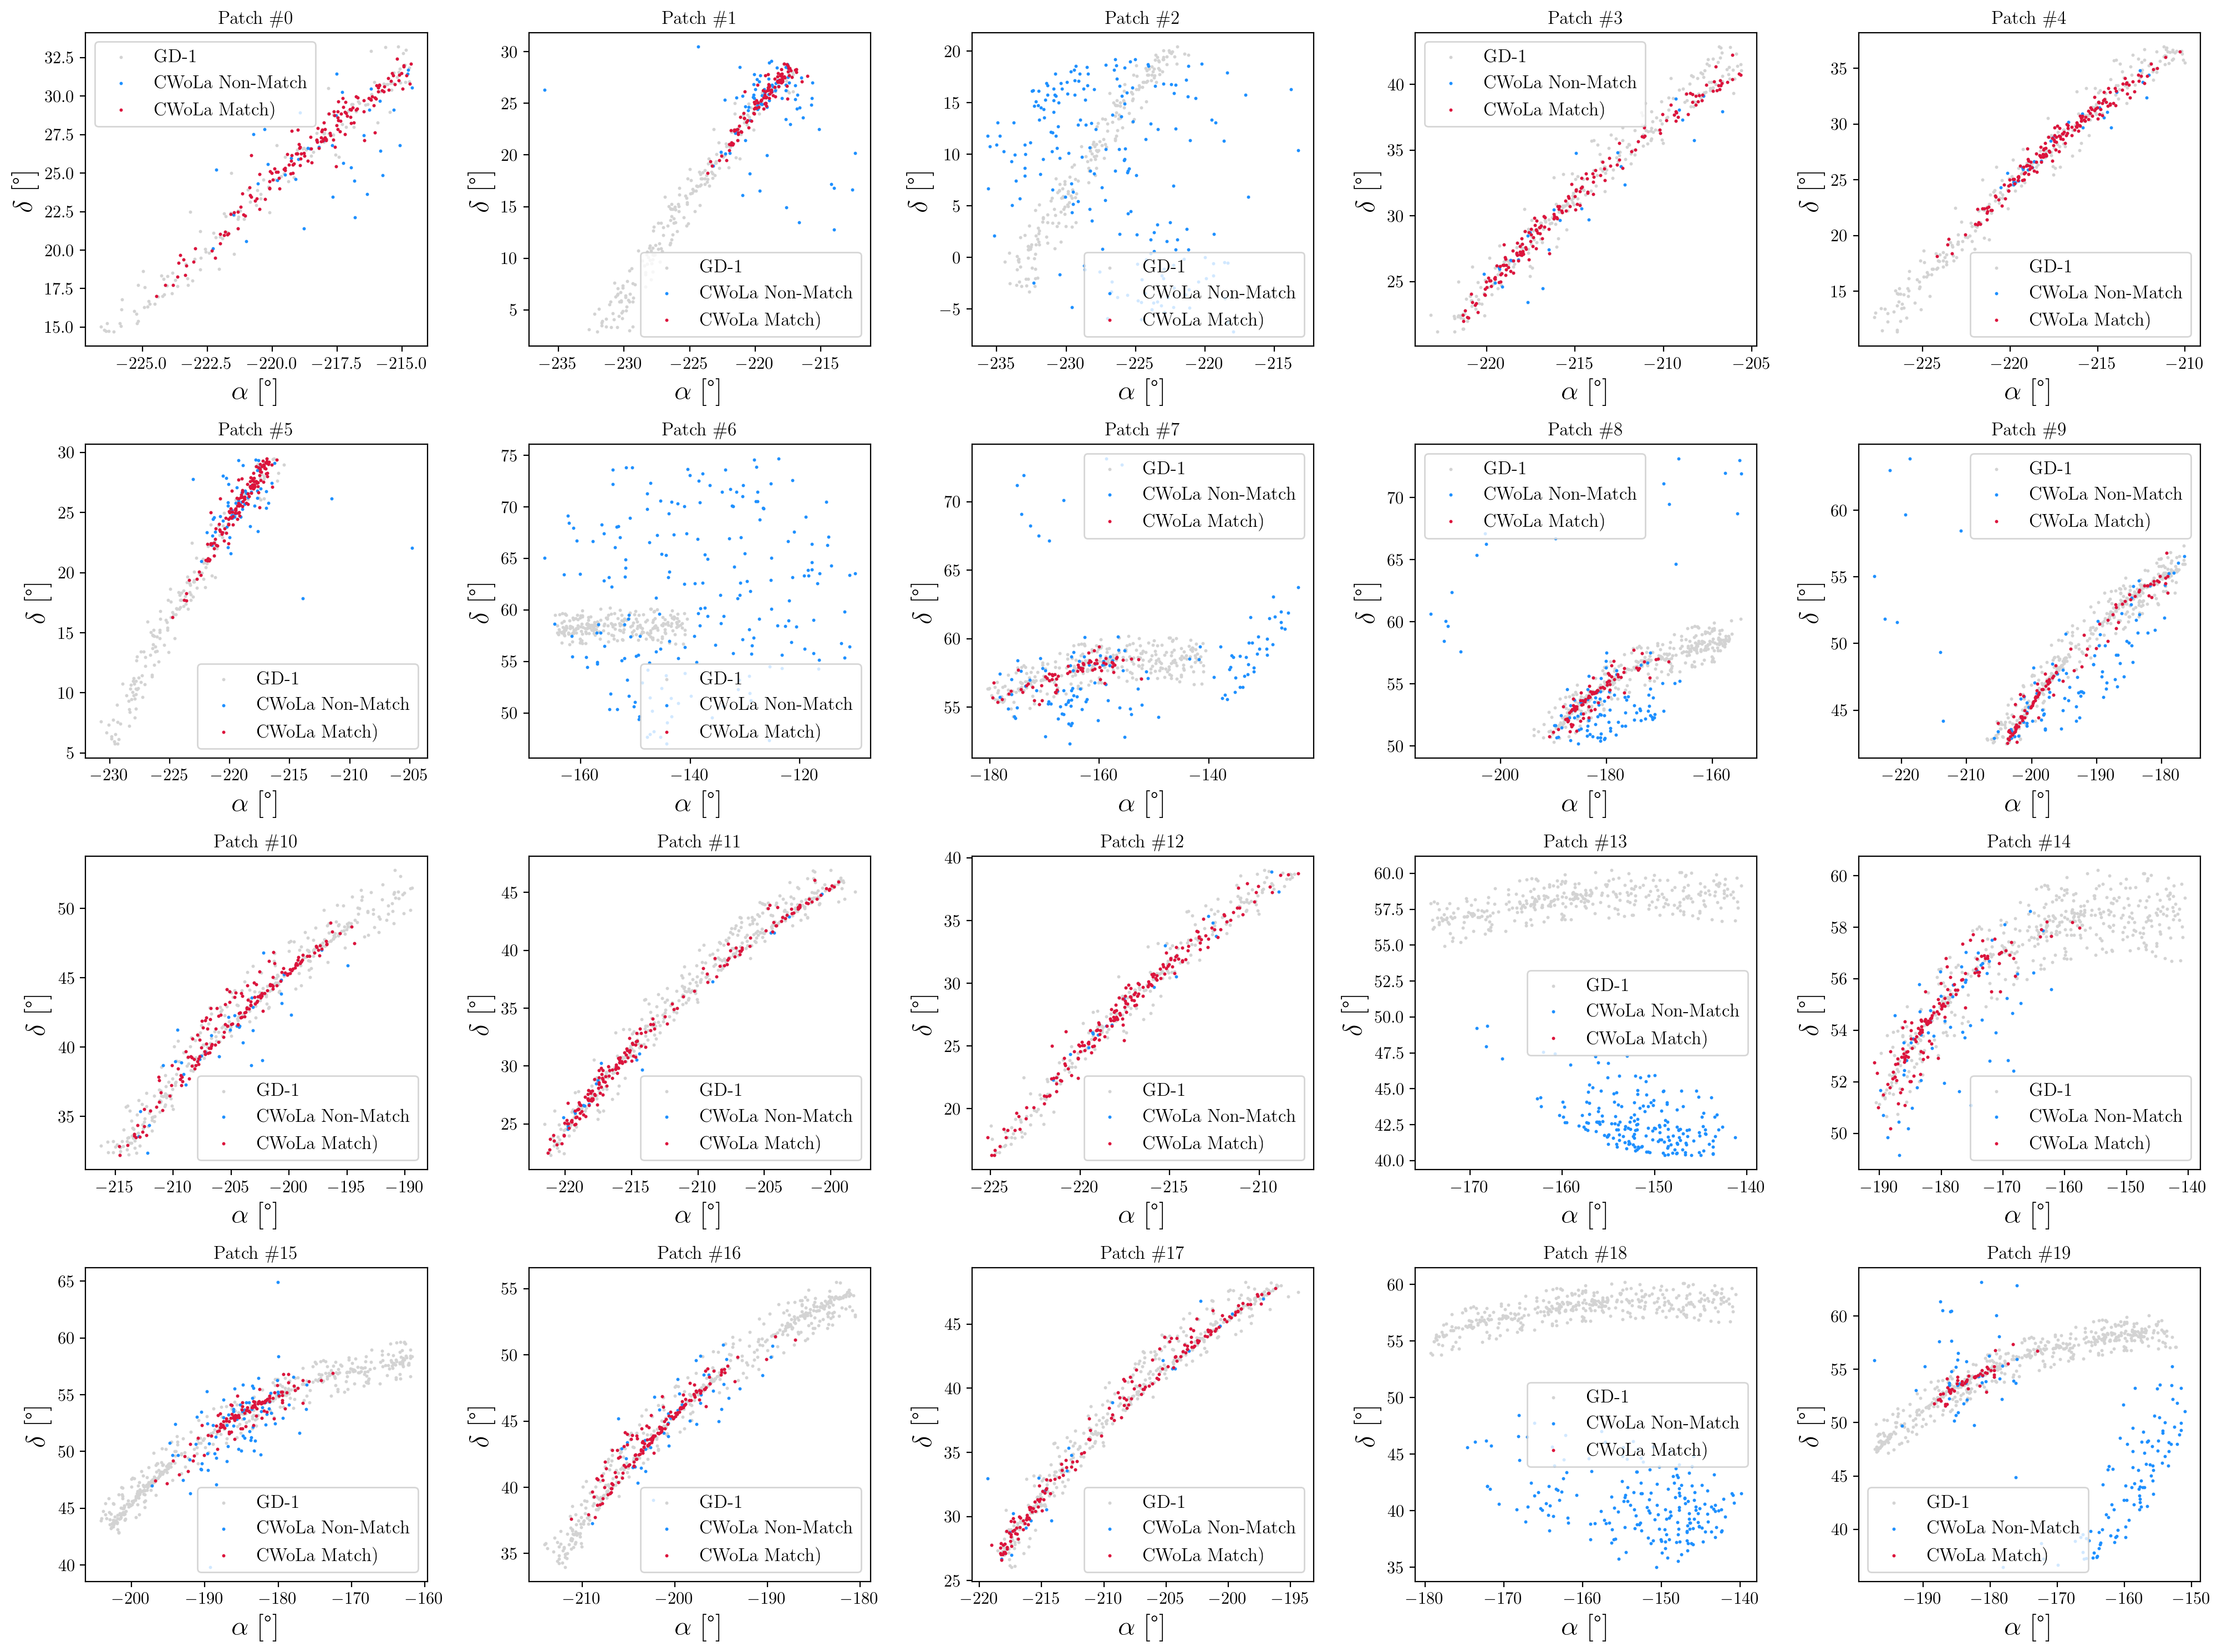

In [86]:
files = sorted(glob("../trained_models/new_sr1_sb3_gpu/patches/patch*/df_test.h5"))

fig, axs = plt.subplots(figsize=(20,15), nrows=4, ncols=5, dpi=200, tight_layout=True)
plt.subplots_adjust(hspace=0.5)

for i, ax in zip(np.arange(20), axs.ravel()):
    file = files[i]
    test = pd.read_hdf(file)
    test = fiducial_cuts(test)
    if len(test) == 0:
        continue
    else:
        stream_stars = test[test.stream]
        n_top_stars = np.min([len(test[test.stream]),200])
        patch_top_stars = test.sort_values('nn_score',ascending=False)[:n_top_stars]
        purity = 100*len(patch_top_stars[patch_top_stars.stream])/len(patch_top_stars)
    #     print(file)
    #     print(purity)
        if purity < 0:
            print("skipping "+str(file))
            continue
        else:
            cwola_stars = patch_top_stars

        stream_stars.reset_index(inplace=True)
        stream_stars.drop_duplicates(subset = 'index')
        stream_stars.drop_duplicates(subset=['α','δ', 'μ_α', 'μ_δ', 'b-r', 'g'], inplace=True)

        cwola_stars.reset_index(inplace=True)
        cwola_stars.drop_duplicates(subset = 'index')
        cwola_stars.drop_duplicates(subset=['α','δ', 'μ_α', 'μ_δ', 'b-r', 'g'], inplace=True)

        stream_stars['α'] = stream_stars['α']-360
        cwola_stars['α'] = cwola_stars['α']-360

        markersize = 5
        ax.scatter(stream_stars.α_wrapped - 360, stream_stars.δ, marker='.', s=markersize, 
                    color="lightgray", label="GD-1")
        ax.scatter(cwola_stars[cwola_stars.stream == False].α_wrapped - 360, cwola_stars[cwola_stars.stream == False].δ, marker='.', s=markersize, 
                    color="dodgerblue", label="CWoLa Non-Match")
        ax.scatter(cwola_stars[cwola_stars.stream].α_wrapped - 360, cwola_stars[cwola_stars.stream].δ, marker='.', s=markersize, 
                    color="crimson", label="CWoLa Match)")
        ax.legend(fontsize=12)
    #     ax.set_xticks(fontsize=16)
    #     ax.set_yticks(fontsize=16)
        ax.set_xlabel(r"$\alpha$ [\textdegree]", fontsize=18);
        ax.set_ylabel(r"$\delta$ [\textdegree]", fontsize=18);
        ax.set_title("Patch \#{}".format(i));
    # plt.xlim(120,220);
    # plt.xlim(-241,-135);
    # plt.ylim(-10,65);
#     plt.savefig("../plots/all_patches.pdf", bbox_inches="tight");

    # print("\n{:,} true GD-1 stars pass fiducial cuts.".format(all_gd1_stars.shape[0]))
    # print("{:,} stars are identified by CWoLa, of which {:,} belong to GD-1.".format(cwola_stars.shape[0], len(cwola_stars[cwola_stars.stream])))

    # print("\nPurity = {:.0f}% in top CWoLa-identified stars".format(100*len(cwola_stars[cwola_stars.stream])/len(cwola_stars)))
    # print("Completeness = {:.0f}% vs. all of GD-1".format(100*len(cwola_stars[cwola_stars.stream])/len(all_gd1_stars)))

In [144]:
# plt.figure(dpi=200)
# files = sorted(glob("../trained_models/new_sr1_sb3_gpu/patches/patch*/df_test.h5"))
# for i in range(20):
#     file = files[i]
#     test = pd.read_hdf(file)
#     test = fiducial_cuts(test)
#     bins = np.linspace(-20,5,100);
#     if i == 2:# or i == 6:# or i == 13 or i == 18: 
#         color = 'crimson'
#     elif i == 6: 
#         color = 'dodgerblue'
#     else: 
#         color = 'lightgrey'
#     plt.hist(test.μ_λ, bins=bins, alpha=0.5, color=color, histtype='step', label="Patch \#{}".format(i))
# plt.legend(fontsize=6);
# plt.xlabel(r'$\mu_\lambda$ [mas/year]');

In [ ]:
files = sorted(glob("../trained_models/new_sr1_sb3_gpu/patches/patch*/df_test.h5"))

fig, axs = plt.subplots(figsize=(20,15), nrows=4, ncols=5, dpi=200, tight_layout=True)
plt.subplots_adjust(hspace=0.5)

for i, ax in zip(np.arange(20), axs.ravel()):
    file = files[i]
    test = pd.read_hdf(file)
    test = fiducial_cuts(test)
    if len(test) == 0:
        continue
    else:
        stream_stars = test[test.stream]
        n_top_stars = np.min([len(test[test.stream]),200])
        patch_top_stars = test.sort_values('nn_score',ascending=False)[:n_top_stars]
        purity = 100*len(patch_top_stars[patch_top_stars.stream])/len(patch_top_stars)
    #     print(file)
    #     print(purity)
        if purity < 0:
            print("skipping "+str(file))
            continue
        else:
            cwola_stars = patch_top_stars

        stream_stars.reset_index(inplace=True)
        stream_stars.drop_duplicates(subset = 'index')
        stream_stars.drop_duplicates(subset=['α','δ', 'μ_α', 'μ_δ', 'b-r', 'g'], inplace=True)

        cwola_stars.reset_index(inplace=True)
        cwola_stars.drop_duplicates(subset = 'index')
        cwola_stars.drop_duplicates(subset=['α','δ', 'μ_α', 'μ_δ', 'b-r', 'g'], inplace=True)

        stream_stars['α'] = stream_stars['α']-360
        cwola_stars['α'] = cwola_stars['α']-360

        markersize = 5
        ax.scatter(stream_stars['μ_ϕcosλ'], stream_stars.μ_λ, marker='.', s=markersize, 
                    color="lightgray", label="GD-1")
        ax.scatter(cwola_stars[cwola_stars.stream == False]['μ_ϕcosλ'], cwola_stars[cwola_stars.stream == False].μ_λ, marker='.', s=markersize, 
                    color="dodgerblue", label="CWoLa Non-Match")
        ax.scatter(cwola_stars[cwola_stars.stream]['μ_ϕcosλ'], cwola_stars[cwola_stars.stream].μ_λ, marker='.', s=markersize, 
                    color="crimson", label="CWoLa Match)")
        ax.legend(fontsize=12)
    #     ax.set_xticks(fontsize=16)
    #     ax.set_yticks(fontsize=16)
        ax.set_xlabel(r"$\mu^*_{\phi}$ [mas/year]", fontsize=18);
        ax.set_ylabel(r"$\mu_{\lambda}$ [mas/year]", fontsize=18);
        ax.set_title("Patch \#{}".format(i));
        ax.set_xlim(-20,15);
        ax.set_ylim(-30,5);
        ax.axvline(-1);
    # plt.xlim(120,220);
    # plt.xlim(-241,-135);
    # plt.ylim(-10,65);
    # plt.savefig("../plots/all_patches.pdf", bbox_inches="tight");

    # print("\n{:,} true GD-1 stars pass fiducial cuts.".format(all_gd1_stars.shape[0]))
    # print("{:,} stars are identified by CWoLa, of which {:,} belong to GD-1.".format(cwola_stars.shape[0], len(cwola_stars[cwola_stars.stream])))

    # print("\nPurity = {:.0f}% in top CWoLa-identified stars".format(100*len(cwola_stars[cwola_stars.stream])/len(cwola_stars)))
    # print("Completeness = {:.0f}% vs. all of GD-1".format(100*len(cwola_stars[cwola_stars.stream])/len(all_gd1_stars)))

In [ ]:
files = sorted(glob("../trained_models/new_sr1_sb3_gpu/patches/patch*/df_test.h5"))

fig, axs = plt.subplots(figsize=(20,15), nrows=4, ncols=5, dpi=200, tight_layout=True)
plt.subplots_adjust(hspace=0.5)

for i, ax in zip(np.arange(20), axs.ravel()):
    file = files[i]
    test = pd.read_hdf(file)
    test = fiducial_cuts(test)
    if len(test) == 0:
        continue
    else:
        stream_stars = test[test.stream]
        n_top_stars = np.min([len(test[test.stream]),200])
        patch_top_stars = test.sort_values('nn_score',ascending=False)[:n_top_stars]
        purity = 100*len(patch_top_stars[patch_top_stars.stream])/len(patch_top_stars)
    #     print(file)
    #     print(purity)
        if purity < 0:
            print("skipping "+str(file))
            continue
        else:
            cwola_stars = patch_top_stars

        stream_stars.reset_index(inplace=True)
        stream_stars.drop_duplicates(subset = 'index')
        stream_stars.drop_duplicates(subset=['α','δ', 'μ_α', 'μ_δ', 'b-r', 'g'], inplace=True)

        cwola_stars.reset_index(inplace=True)
        cwola_stars.drop_duplicates(subset = 'index')
        cwola_stars.drop_duplicates(subset=['α','δ', 'μ_α', 'μ_δ', 'b-r', 'g'], inplace=True)

        stream_stars['α'] = stream_stars['α']-360
        cwola_stars['α'] = cwola_stars['α']-360

        markersize = 5
        ax.scatter(stream_stars['b-r'], stream_stars.g, marker='.', s=markersize, 
                    color="lightgray", label="GD-1")
        ax.scatter(cwola_stars[cwola_stars.stream == False]['b-r'], cwola_stars[cwola_stars.stream == False].g, marker='.', s=markersize, 
                    color="dodgerblue", label="CWoLa Non-Match")
        ax.scatter(cwola_stars[cwola_stars.stream]['b-r'], cwola_stars[cwola_stars.stream].g, marker='.', s=markersize, 
                    color="crimson", label="CWoLa Match)")
        ax.legend(fontsize=12)
    #     ax.set_xticks(fontsize=16)
    #     ax.set_yticks(fontsize=16)
        ax.set_xlabel(r"$b-r$", fontsize=18);
        ax.set_ylabel(r"$g$", fontsize=18);
        ax.set_title("Patch \#{}".format(i));
        ax.set_xlim(-0,1.25);
        ax.set_ylim(15,21)
        ax.invert_yaxis();
    # plt.xlim(120,220);
    # plt.xlim(-241,-135);
    # plt.ylim(-10,65);
    # plt.savefig("../plots/all_patches.pdf", bbox_inches="tight");

    # print("\n{:,} true GD-1 stars pass fiducial cuts.".format(all_gd1_stars.shape[0]))
    # print("{:,} stars are identified by CWoLa, of which {:,} belong to GD-1.".format(cwola_stars.shape[0], len(cwola_stars[cwola_stars.stream])))

    # print("\nPurity = {:.0f}% in top CWoLa-identified stars".format(100*len(cwola_stars[cwola_stars.stream])/len(cwola_stars)))
    # print("Completeness = {:.0f}% vs. all of GD-1".format(100*len(cwola_stars[cwola_stars.stream])/len(all_gd1_stars)))

# Rotate coordinates to stream-aligned $\phi_1$ and $\phi_2$

In [ ]:
import astropy.units as u
from gala.coordinates import GD1Koposov10
from astropy.coordinates import SkyCoord

In [ ]:
gd1_frame = GD1Koposov10()

### All GD-1 stars
coord_icrs = SkyCoord(ra=(all_gd1_stars['α_wrapped'] - 360)*u.degree, dec=all_gd1_stars.δ*u.degree, frame='icrs')
coord_gd1 = coord_icrs.transform_to(gd1_frame)
all_gd1_stars['ϕ1'] = coord_gd1.phi1.degree
all_gd1_stars['ϕ2'] = coord_gd1.phi2.degree

### CWoLa stars
coord_icrs = SkyCoord(ra=(cwola_stars['α_wrapped'] - 360)*u.degree, dec=cwola_stars.δ*u.degree, frame='icrs')
coord_gd1 = coord_icrs.transform_to(gd1_frame)
cwola_stars['ϕ1'] = coord_gd1.phi1.degree
cwola_stars['ϕ2'] = coord_gd1.phi2.degree

In [ ]:
markersize = 5
plt.figure(dpi=200, figsize=(10,4))
plt.scatter(all_gd1_stars['ϕ1'], all_gd1_stars['ϕ2'], marker='.', s=markersize, color="lightgray", label="GD-1")
plt.scatter(cwola_stars['ϕ1'], cwola_stars['ϕ2'], marker='.', s=markersize, color="crimson", label="CWoLa")
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r"$\phi_1$ [\textdegree]", fontsize=18);
plt.ylabel(r"$\phi_2$ [\textdegree]", fontsize=18);

In [ ]:
markersize = 5
fig, axs = plt.subplots(nrows=3, ncols=1, dpi=200, figsize=(10,6))

# gd1_stars = all_gd1_stars
gd1_stars = all_gd1_stars[(all_gd1_stars.g < 20.2) & (0.5 < all_gd1_stars['b-r']) & (all_gd1_stars['b-r'] < 1)]

ax = axs[0]
ax.scatter(gd1_stars['ϕ1'], gd1_stars['ϕ2'], marker='.', s=markersize, color="gray", label="GD-1")
ax.legend(fontsize=16)
ax.set_xlabel(r"$\phi_1$ [\textdegree]", fontsize=18);
ax.set_ylabel(r"$\phi_2$ [\textdegree]", fontsize=18);
ax.axvline(-40,c='k',linestyle='dashed',lw=1)
ax.axvline(-20,c='k',linestyle='dashed',lw=1)
ax.axvline(-14,c='k',lw=1)
ax.arrow(-30,-2,-2.7,2.5,width=0.1,color='k')
ax.text(-31,-2.8,'Spur')
ax.set_ylim(-5.5,3)
ax.set_xlim(-95,15)
ax.text(-14+0.5,-5,'``Blob", or possible progenitor',rotation=0)

ax = axs[1]
ax.scatter(cwola_stars['ϕ1'], cwola_stars['ϕ2'], marker='.', s=markersize, color="crimson", label="CWoLa")
ax.legend(fontsize=16)
ax.set_xlabel(r"$\phi_1$ [\textdegree]", fontsize=18);
ax.set_ylabel(r"$\phi_2$ [\textdegree]", fontsize=18);
ax.set_ylim(-5.5,3)
ax.set_xlim(-95,15)
ax.text(-40+0.2,-3.4,'Gap',rotation=-90)
ax.axvline(-40,c='k',linestyle="dashed",lw=1)
ax.arrow(-30,-2,-2.7,2.5,width=0.1,color='k')
ax.text(-31,-2.8,'Spur')
ax.axvline(-14,c='k',lw=1)
ax.text(-20+0.2,-3.4,'Gap',rotation=-90)
ax.axvline(-20,c='k',linestyle="dashed",lw=1)

ax = axs[2]
ax.set_xlabel(r"$\phi_1$ [\textdegree]", fontsize=18);
ax.set_xlim(-95,15);

bins = np.linspace(np.min(gd1_stars['ϕ1']),np.max(gd1_stars['ϕ1']),50)
counts_gd1, _   = np.histogram(gd1_stars['ϕ1'], bins=bins) 
counts_cwola, _ = np.histogram(cwola_stars['ϕ1'], bins=bins) 
ax.errorbar(0.5*(bins[1:]+bins[:-1]),counts_gd1, yerr=np.sqrt(counts_gd1),  marker='.',c='gray', label='GD-1')
ax.errorbar(0.5*(bins[1:]+bins[:-1]),counts_cwola, yerr=np.sqrt(counts_cwola), marker='.', c='crimson', label='CWoLa')
ax.legend(loc='upper left');
ax.axvline(-14,c='k',lw=1)
ax.axvline(-20,c='k',linestyle="dashed",lw=1)
ax.axvline(-40,c='k',linestyle="dashed",lw=1)
ax.set_ylabel('Counts');
# ax.set_ylim(0,80);
# plt.savefig("phi1_phi2_brg_cuts.pdf")

# Add promising stars

In [ ]:
labeled = cwola_stars[cwola_stars.stream]
unlabeled = cwola_stars[cwola_stars.stream == False]

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(12,4), dpi=300, tight_layout=True)

ax = axs[0]
ax.set_title("Stellar Positions")
ax.scatter(all_gd1_stars.α, all_gd1_stars.δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.α, labeled.δ, marker='.', color="crimson",label="Labeled GD1 (Top {})".format(n_top_stars))
ax.scatter(unlabeled.α, unlabeled.δ, marker='.', color="dodgerblue", label="Unlabeled (Top {})".format(n_top_stars))
# ax.set_xlim(-15,15)
# ax.set_ylim(-15,15)
ax.legend()
ax.set_xlabel(r"$\alpha$[\textdegree]")
ax.set_ylabel(r"$\delta$[\textdegree]");

ax = axs[1]
ax.set_title("Stellar Velocities")
ax.scatter(all_gd1_stars.μ_α, all_gd1_stars.μ_δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.μ_α, labeled.μ_δ, marker='.', color="crimson", label="CWoLa Top {} (Labeled)".format(n_top_stars))
ax.scatter(unlabeled.μ_α, unlabeled.μ_δ, marker='.', color="dodgerblue", label="CWoLa Top {} (Unlabeled)".format(n_top_stars))
# ax.set_xlim(-15,15)
# ax.set_ylim(-15,15)
ax.set_xlabel(r"$\mu_{\alpha}$")
ax.set_ylabel(r"$\mu_{\delta}$");

ax = axs[2]
ax.set_title("Magnitude vs. Color")
ax.scatter(all_gd1_stars.color, all_gd1_stars.mag, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.color, labeled.mag, marker='.', color="crimson", label="CWoLa Top {} (Labeled)".format(n_top_stars))
ax.scatter(unlabeled.color, unlabeled.mag, marker='.', color="dodgerblue", label="CWoLa Top {} (Unlabeled)".format(n_top_stars))
ax.set_xlabel(r"Color")
ax.set_ylabel(r"Magnitude");
# plt.savefig("../plots/mislabeled_triptych.png")

Identify promising unlabeled stars...

In [ ]:
from scipy.spatial import distance_matrix
cols = ["μ_α", "δ", "α", "color", "mag"]
dists = distance_matrix(labeled[cols].to_numpy(), unlabeled[cols].to_numpy())
closest_labeled = labeled.iloc[dists.argmin(axis=0)]
deltas = unlabeled[cols].to_numpy()-closest_labeled[cols].to_numpy()
distances = np.sqrt(np.sum(deltas**2, axis=1))
unlabeled['5d_distance'] = distances

plt.figure(dpi=300)
plt.hist(unlabeled["5d_distance"], bins=60)
plt.title("5D Distances: Unlabeled to Closest Labeled Star");
plt.ylabel("Counts")
plt.xlabel("5D Euclidean Distance");
# plt.savefig("../plots/5d_distance.png")

In [ ]:
# promising = unlabeled[(unlabeled['5d_distance'] < 1)] # restrict by a specific distance
promising = unlabeled[(unlabeled['5d_distance'] < unlabeled['5d_distance'].quantile(0.1))] # restrict to the top x%

In [ ]:
len(promising)

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(12,4), dpi=300, tight_layout=True)

ax = axs[0]
ax.set_title("Stellar Positions")
ax.scatter(all_gd1_stars.α, all_gd1_stars.δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.α, labeled.δ, marker='.', color="crimson",label="Labeled GD1 (Top {})".format(n_top_stars))
ax.scatter(promising.α, promising.δ, marker='.', color="dodgerblue", label="promising (Top {})".format(n_top_stars))
# ax.set_xlim(-15,15)
# ax.set_ylim(-15,15)
ax.legend()
ax.set_xlabel(r"$\alpha$[\textdegree]")
ax.set_ylabel(r"$\delta$[\textdegree]");

ax = axs[1]
ax.set_title("Stellar Velocities")
ax.scatter(all_gd1_stars.μ_α, all_gd1_stars.μ_δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.μ_α, labeled.μ_δ, marker='.', color="crimson", label="CWoLa Top {} (Labeled)".format(n_top_stars))
ax.scatter(promising.μ_α, promising.μ_δ, marker='.', color="dodgerblue", label="CWoLa Top {} (promising)".format(n_top_stars))
# ax.set_xlim(-15,15)
# ax.set_ylim(-15,15)
ax.set_xlabel(r"$\mu_{\alpha}$")
ax.set_ylabel(r"$\mu_{\delta}$");

ax = axs[2]
ax.set_title("Magnitude vs. Color")
ax.scatter(all_gd1_stars.color, all_gd1_stars.mag, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.color, labeled.mag, marker='.', color="crimson", label="CWoLa Top {} (Labeled)".format(n_top_stars))
ax.scatter(promising.color, promising.mag, marker='.', color="dodgerblue", label="CWoLa Top {} (promising)".format(n_top_stars))
ax.set_xlabel(r"Color")
ax.set_ylabel(r"Magnitude");
# plt.savefig("../plots/mislabeled_triptych.png")

In [ ]:
plt.figure(dpi=200, figsize=(12,4))
plt.scatter(all_gd1_stars.α, all_gd1_stars.δ, marker='.', s=10, 
            color="lightgray", label="GD1")
plt.scatter(promising.α, promising.δ, marker='.', s=10, 
            color="dodgerblue", label="CWoLa (Promising Candidates)")
plt.scatter(cwola_stars[cwola_stars.stream].α, cwola_stars[cwola_stars.stream].δ, marker='.', s=10, 
            color="crimson", label="CWoLa (Match)")
plt.legend(fontsize=13)
plt.xlabel(r"$\alpha$ [\textdegree]");
plt.ylabel(r"$\delta$ [\textdegree]");
plt.xlim(120,220);
# plt.savefig("via_machinae_aps_50patches_top50.png");